In [1]:
%pylab inline
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

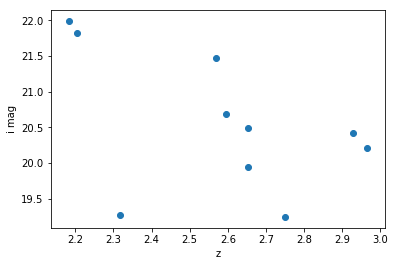

In [3]:
# just make up a few random redshifts between z=2 and z=3, then assign apparent mags according 
# to the BOSS DR9 QLF
nqso = 10
np.random.seed(12345)
zin = 2.0 + np.random.rand(nqso)
kcorr = sqbase.ContinuumKCorr('SDSS-i',1450)
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (17,22),(2.0,3.0),
                         kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.appMag)
xlabel('z')
ylabel('i mag');

In [4]:
# add the fiducial quasar SED model from BOSS DR9, don't add IGM absorption
sedVars = get_BossDr9_model_vars(qsos,wave,0,noforest=True)
qsos.addVars(sedVars)

In [5]:
# need to define photometry in SDSS system in order to calibrate apparent mags
qsos.loadPhotoMap([('SDSS','Legacy'),])

In [6]:
# ready to generate spectra. iteration is necessary to converge on the per-object k-correction,
# after two steps the maximum error on the absolute mags is <<1%
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  10  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.0681259, rms = 0.1268365, |max| = 0.2896980
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0013194, rms = 0.0012750, |max| = 0.0033405


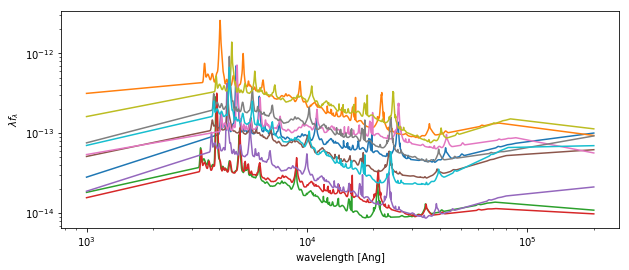

In [7]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$');

In [8]:
# the parameter values for each spectrum
qsos.data

absMag,appMag,z,slopes [5],"emLines [62,3]",synMag [5],synFlux [5]
float32,float32,float32,float32,float32,float32,float32
-24.7405,20.4188,2.92962,-1.88898 .. -1.36107,1033.72 .. 323.155,21.3582 .. 20.3617,2.86231 .. 7.16654
-25.5847,19.264,2.31638,-1.25556 .. -0.638748,1034.31 .. 324.459,19.4391 .. 19.0888,16.7631 .. 23.1471
-22.7652,21.9861,2.18392,-1.60816 .. -0.775977,1033.71 .. 290.716,21.8998 .. 21.8419,1.7381 .. 1.83339
-22.7697,21.8203,2.20456,-1.63361 .. -0.851231,1034.15 .. 311.48,21.9884 .. 21.5956,1.60187 .. 2.30012
-23.6903,21.4767,2.56772,-1.87692 .. -1.28331,1033.5 .. 268.032,21.7017 .. 21.3046,2.08608 .. 3.00726
-24.4212,20.684,2.59554,-1.57389 .. -1.18543,1034.33 .. 409.85,21.0792 .. 20.4899,3.70105 .. 6.36883
-24.9119,20.2045,2.96451,-1.47492 .. -0.461103,1033.18 .. 253.642,21.2225 .. 20.0896,3.24347 .. 9.2082
-25.1493,19.9426,2.65318,-1.71456 .. -1.48518,1033.68 .. 270.138,20.4585 .. 19.7782,6.55569 .. 12.2669
-25.8453,19.242,2.74891,-1.53337 .. -0.670226,1033.57 .. 263.723,19.9271 .. 19.1167,10.6942 .. 22.5592


In [9]:
# save the spectra to a fits bin table
save_spectra(wave,spectra,'quickspeclib')

In [10]:
# restore the spectra
wave,spec = load_spectra('quickspeclib')